In [2]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import math
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [3]:
batch_size = 32 
num_classes = 10
epochs = 30

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow(
        x_train,
        y_train,        
        batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow(
        x_test,
        y_test,        
        batch_size=batch_size)

In [5]:
def build_model():
    net_input = Input(shape=x_train.shape[1:])
    
    net = Conv2D(32, (3, 3), padding='same', activation='relu')(net_input)
    net = Dropout(0.2)(net)
    
    net = Conv2D(32,(3,3),padding='same', activation='relu')(net)
    net = MaxPooling2D(pool_size=(2,2))(net)
 
    net = Conv2D(64,(3,3),padding='same',activation='relu')(net)
    net = Dropout(0.2)(net)
 
    net = Conv2D(64,(3,3),padding='same',activation='relu')(net)
    net = MaxPooling2D(pool_size=(2,2))(net)
 
    net = Conv2D(128,(3,3),padding='same',activation='relu')(net)
    net = Dropout(0.2)(net)
 
    net = Conv2D(128,(3,3),padding='same',activation='relu')(net)
    net = MaxPooling2D(pool_size=(2,2))(net)
    
    net = Flatten(name='flatten')(net) 
    net = Dense(1024, activation='relu')(net)
    net = Dense(512, activation='relu')(net)
    net = Dense(256, activation='relu')(net)
    softmax_output = Dense(num_classes, activation='softmax')(net)

    model = Model(net_input, softmax_output)
    
    model.compile(optimizer=SGD(lr=0.0, momentum=0.9, nesterov=True, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print(' lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.9
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [8]:
model = build_model()

print(model.summary())

model.fit_generator(
        train_generator,
        steps_per_epoch= 100,
        epochs=epochs,callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
__________

Epoch 25/30
100/100 [==============================] - 52s 520ms/step - loss: 2.3068 - acc: 0.1009 - val_loss: 2.3075 - val_acc: 0.1019
Epoch 26/30
100/100 [==============================] - 56s 559ms/step - loss: 2.3071 - acc: 0.1047 - val_loss: 2.3065 - val_acc: 0.1005
Epoch 27/30
100/100 [==============================] - 54s 538ms/step - loss: 2.3079 - acc: 0.0947 - val_loss: 2.3054 - val_acc: 0.1006
Epoch 28/30
100/100 [==============================] - 55s 549ms/step - loss: 2.3062 - acc: 0.1006 - val_loss: 2.3101 - val_acc: 0.0934
Epoch 29/30
100/100 [==============================] - 53s 532ms/step - loss: 2.3075 - acc: 0.0959 - val_loss: 2.3035 - val_acc: 0.1055
Epoch 30/30
100/100 [==============================] - 56s 562ms/step - loss: 2.3062 - acc: 0.1044 - val_loss: 2.3061 - val_acc: 0.0950


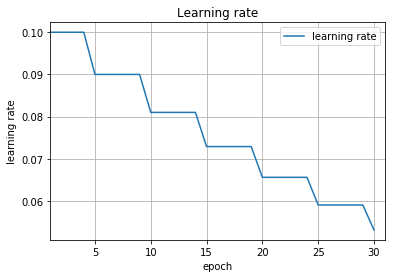

In [9]:
# plot learning rate
fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()
